In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

In [2]:
train_run = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\tumors")

In [3]:
runs = [x for x in train_run.iterdir() if x.is_dir()]
runs_df = pd.DataFrame(runs, columns=["run_path"])
runs_df["run_date"] = runs_df["run_path"].apply(lambda x: x.name)

In [4]:
def get_run_info(row):
    file_path = row["run_path"] / "params.txt"
    with open(file_path, "r") as f:
        res_dict = {}
        for line in f:
            line = line.strip()
            var_name, var_value = line.split("=")
            var_name = var_name.strip()
            var_value = var_value.strip()
            if var_name == "PARAMS":
                l = eval(var_value)
                res_dict.update(l)
            else:
                var_value = Path(var_value)
                res_dict[var_name] = var_value
    return res_dict


res = runs_df.apply(get_run_info, axis=1, result_type="expand")
runs_df = pd.concat([runs_df, res], axis=1)

In [5]:
# pd.read_csv(row.run_path / "results.csv")
def get_metrics(row):
    file_path = row["run_path"] / "results.csv"
    if file_path.exists():
        df = pd.read_csv(file_path).iloc[0]
        return df
    else:
        print(f"File {file_path} not found")
        return np.nan


res = runs_df.apply(get_metrics, axis=1, result_type="expand")
runs_df = pd.concat([runs_df, res], axis=1)
runs_df

,run_path,run_date,batch_size,n_ep,lr,n_tiles,n_workers,wd,device,display,PATH_SUMMARY_DATA,PATH_FEATURES_DIR,export_path,val_auc,val_loss,train_auc,train_loss
0,C:\Users\inserm\Documents\histo_sign\trainings...,2024-03-25_11-12-38,4096,5,0.00010,8000,0,0,cuda:0,True,C:\Users\inserm\Documents\histo_sign\dataset\p...,C:\Users\inserm\Documents\histo_sign\dataset\f...,C:\Users\inserm\Documents\histo_sign\trainings...,0.888664,0.570307,0.925802,0.480373
1,C:\Users\inserm\Documents\histo_sign\trainings...,2024-03-25_11-48-25,4096,10,0.00010,8000,0,0,cuda:0,True,C:\Users\inserm\Documents\histo_sign\dataset\p...,C:\Users\inserm\Documents\histo_sign\dataset\f...,C:\Users\inserm\Documents\histo_sign\trainings...,0.889157,0.574158,0.938064,0.439757
2,C:\Users\inserm\Documents\histo_sign\trainings...,2024-03-25_13-13-29,4096,10,0.00005,8000,0,0,cuda:0,True,C:\Users\inserm\Documents\histo_sign\dataset\p...,C:\Users\inserm\Documents\histo_sign\dataset\f...,C:\Users\inserm\Documents\histo_sign\trainings...,0.889590,0.569525,0.930373,0.465283
3,C:\Users\inserm\Documents\histo_sign\trainings...,2024-03-25_14-43-57,4096,20,0.00005,8000,0,0,cuda:0,True,C:\Users\inserm\Documents\histo_sign\dataset\p...,C:\Users\inserm\Documents\histo_sign\dataset\f...,C:\Users\inserm\Documents\histo_sign\trainings...,0.891071,0.570412,0.938877,0.436640


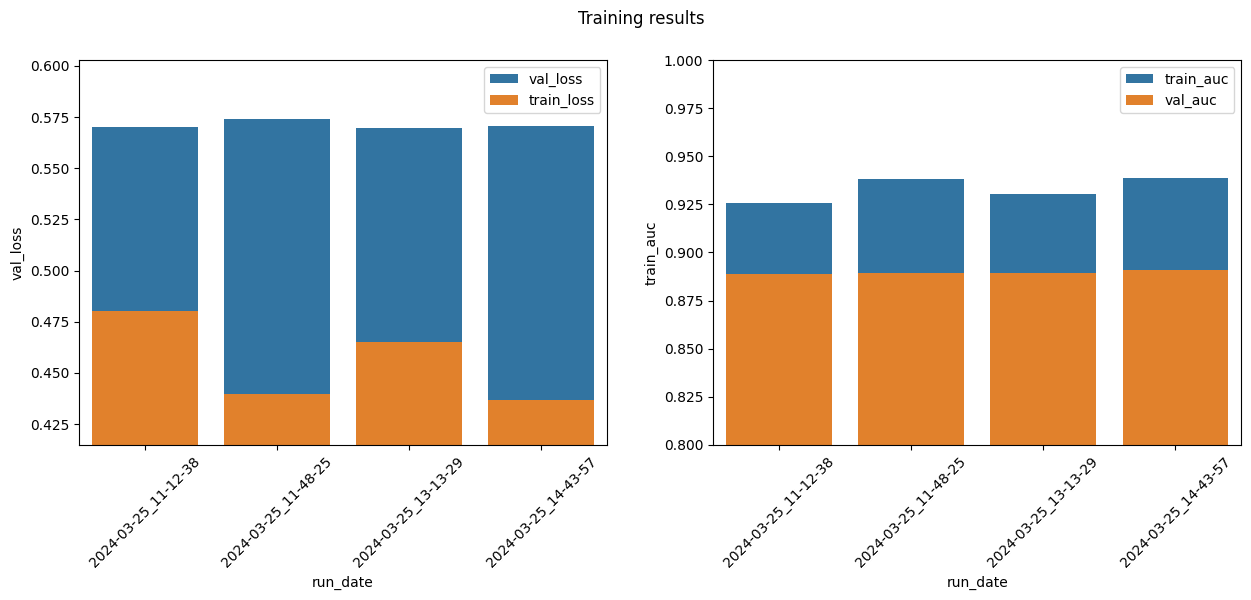

In [6]:
# sns.barplot(data=runs_df, x="run_date", y="val_loss")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(data=runs_df, x="run_date", y="val_loss", ax=axes[0], label="val_loss")
sns.barplot(data=runs_df, x="run_date", y="train_loss", ax=axes[0], label="train_loss")
sns.barplot(data=runs_df, x="run_date", y="train_auc", ax=axes[1], label="train_auc")
sns.barplot(data=runs_df, x="run_date", y="val_auc", ax=axes[1], label="val_auc")

axes[0].xaxis.set_tick_params(rotation=45)
axes[1].xaxis.set_tick_params(rotation=45)
axes[1].set_ylim(0.8, 1)
# axes[0].set_yscale("log")
axes[0].set_ylim(runs_df["train_loss"].min() * 0.95, runs_df["val_loss"].max() * 1.05)

plt.suptitle("Training results")
plt.show()

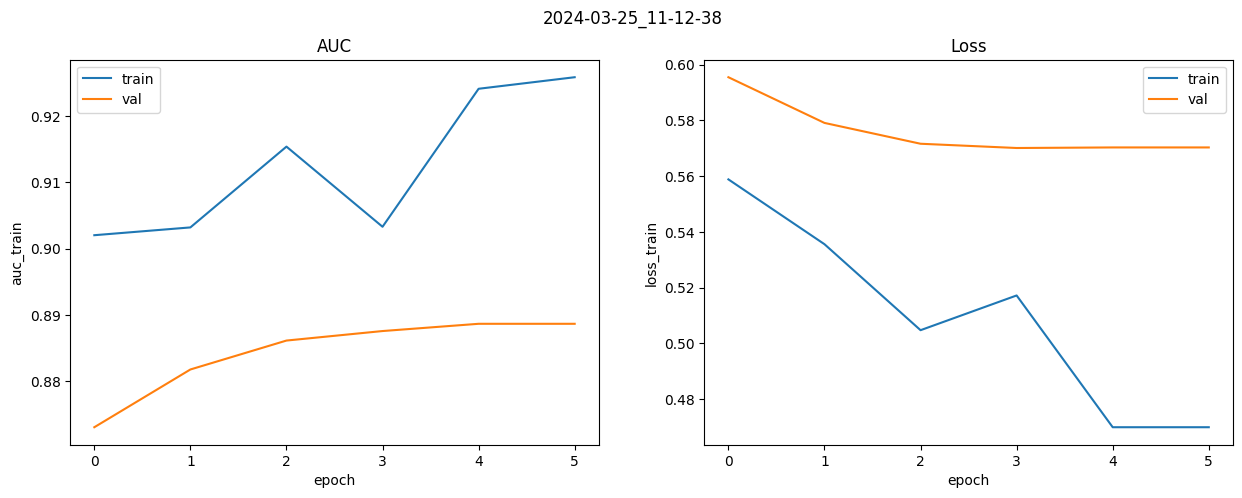

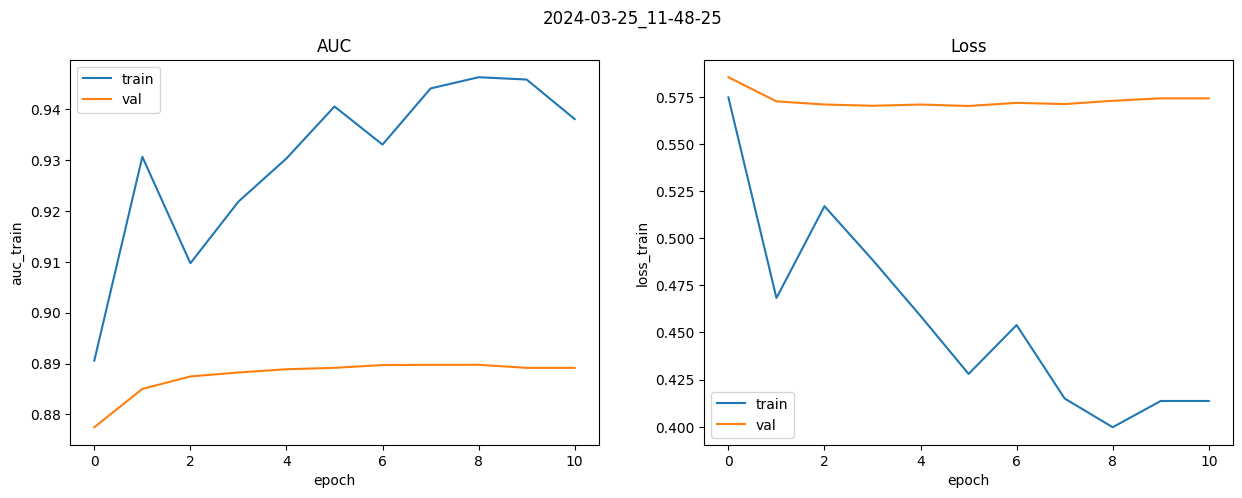

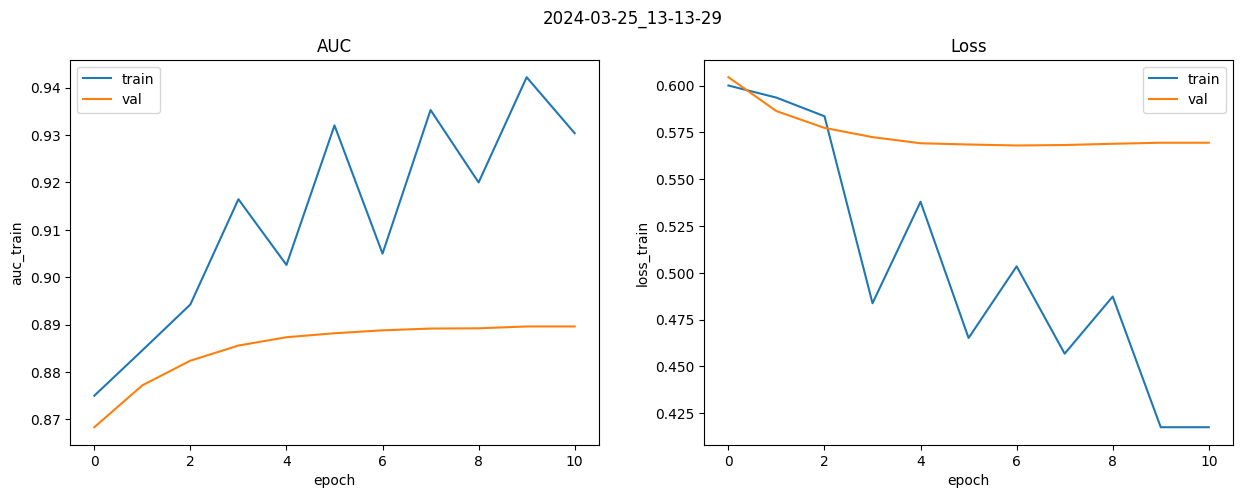

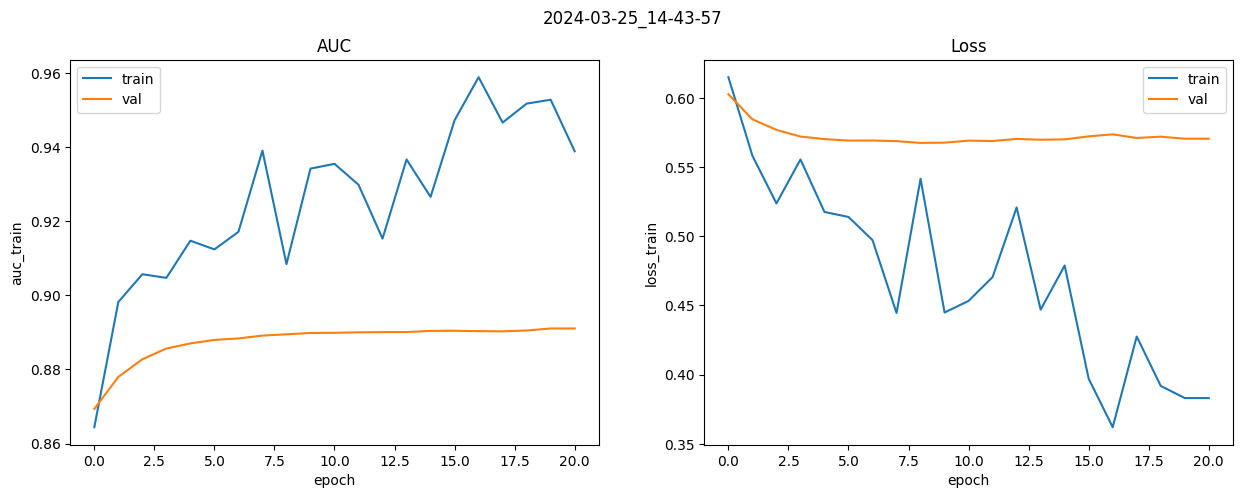

In [7]:
def plot_run(row):
    auc_train = np.load(row.run_path / "auc_train.npy")
    auc_val = np.load(row.run_path / "val_auc.npy")
    loss_train = np.load(row.run_path / "loss_train.npy")
    loss_val = np.load(row.run_path / "val_loss.npy")

    res_df = pd.DataFrame(
        {"auc_train": auc_train, "auc_val": auc_val, "loss_train": loss_train, "loss_val": loss_val}
    )
    res_df["epoch"] = res_df.index

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(data=res_df, x="epoch", y="auc_train", ax=ax[0], label="train")
    sns.lineplot(data=res_df, x="epoch", y="auc_val", ax=ax[0], label="val")
    ax[0].set_title("AUC")

    sns.lineplot(data=res_df, x="epoch", y="loss_train", ax=ax[1], label="train")
    sns.lineplot(data=res_df, x="epoch", y="loss_val", ax=ax[1], label="val")
    ax[1].set_title("Loss")

    plt.suptitle(row.run_date)
    plt.show()


for i in range(runs_df.shape[0]):
    plot_run(runs_df.iloc[i])